# Introducción

Este informe, a través del análisis de Big Data, pretende identificar las calles de la ciudad con agujeros, estimar los costes de reparación/mantenimiento e identificar los segmentos que tienen el mayor impacto negativo en el bienestar de los ciudadanos.

# Parametrización de variables

## Ajuste de los parámetros

In [1]:
from datetime import datetime as dt
from datetime import timedelta as td

cost_per_meter = 23.4
lane_size = 2.8

# city = 'Miraflores'
# table = 'pe_lima_waze_alerts'
# start_date = dt(2019,6,15)
# end_date = dt(2019,6,30)

# osm_place = "Distrito de Miraflores"

city = 'Miraflores'
table = 'pe_lima_waze_alerts'
start_date = dt(2019,6,15)
end_date = dt(2019,7,15)
osm_place = "Distrito de Miraflores"
which_result=1

## Imports and Configuration

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import logging
import warnings
import datetime
import pytz
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx 
import osmnx as ox
import matplotlib.pyplot as plt

from matplotlib import colors, cm
from pathlib import Path 
from shapely.geometry import Point
from IPython.display import display, Markdown
from scipy.stats import pareto


# Setting matplotlib font size
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)

current_path = Path().resolve()
abs_path = str(current_path.parent)
sys.path.append(abs_path)

RAW_PATH = current_path.parent / 'data' / 'raw'
OUTPUT_PATH = current_path.parent / 'data' / 'output' / city

warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)


In [3]:
import scripts.pot_holes_cost as phc
from scripts.mod_simplify import simplify_graph

In [4]:
date_string_parser='%d/%m/%y'
print(f"""Los parámetros definidos para este informe son los siguientes:

Rutas:

Costo promedio por metro de reparación de carreteras: {cost_per_meter:.2f}U$/m^2
Ancho medio de vía: {lane_size:.2f}m

Período
Fecha de inicio de las alertas: {start_date.strftime(date_string_parser)}
Fecha de finalización de las alertas: {end_date.strftime(date_string_parser)}""")

Los parámetros definidos para este informe son los siguientes:

Rutas:

Costo promedio por metro de reparación de carreteras: 23.40U$/m^2
Ancho medio de vía: 2.80m

Período
Fecha de inicio de las alertas: 15/06/19
Fecha de finalización de las alertas: 15/07/19


# Obtención de los datos

## Agujeros

Los datos sobre los hoyos fueron extraídos de nuestro servidor Big Data, que almacena la información de Waze. Las alertas de huecos son creadas por los propios usuarios de la aplicación para alertar a otros de las condiciones de la carretera.

In [5]:
pot_holes = phc.download_potholes_data(template_fp='../templates/pot_holes.sql', city=city, table=table, 
                                       start_date=start_date, end_date=end_date, workgroup='Test')

In [6]:
display(Markdown(
    f"La siguiente tabla muestra los cinco hoyos con el mayor número de quejas en la ciudad en el período comprendido entre {start_date.strftime('%d/%m/%y')} - {end_date.strftime('%d/%m/%y')}"))

La siguiente tabla muestra los cinco hoyos con el mayor número de quejas en la ciudad en el período comprendido entre 15/06/19 - 15/07/19

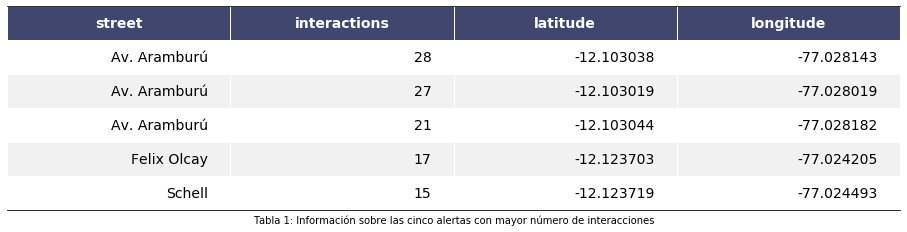

In [7]:
top5 = pot_holes[['street', 'interactions', 'latitude', 'longitude', ]].sort_values('interactions', ascending=False).head()
top5['latitude'] = top5['latitude'].apply(lambda x: f"{x:,.6f}")
top5['longitude'] = top5['longitude'].apply(lambda x: f"{x:,.6f}")
fig, ax, table = phc.render_mpl_table(top5, 'potholes_top5.png', city)#col_width=7
ax.set_xlabel(f"Tabla 1: Información sobre las cinco alertas con mayor número de interacciones");

In [8]:
display(Markdown(f"""Alertas totales: {pot_holes.shape[0]}

Interacciones totales: {pot_holes.interactions.sum()}"""))

Alertas totales: 140

Interacciones totales: 734

## Open Street Maps (OSM)

Para complementar nuestro estudio, descargamos la información de calles de la ciudad disponible en Open Street Maps, un proyecto de cartografía colaborativa para crear un mapa del mundo gratuito y editable. Con una red de más de 2 millones de colaboradores en todo el mundo, OSM ofrece mapas detallados de varias localizaciones y es una excelente fuente de información sobre la estructura vial de los municipios.

In [9]:
G = phc.download_osm_graph(city, osm_place, simplify=False, which_result=which_result)

In [10]:
G_proj = ox.project_graph(G) 

La imagen de abajo muestra todas las calles públicas de la ciudad registradas en el OSM.

In [11]:
fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=12, show=False, axis_off=False, edge_linewidth=0.2)
ax.margins(0)
ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel(f"Figura 1: Vías públicas de la ciudad de {city} obtenidas a través del Open Street Maps");

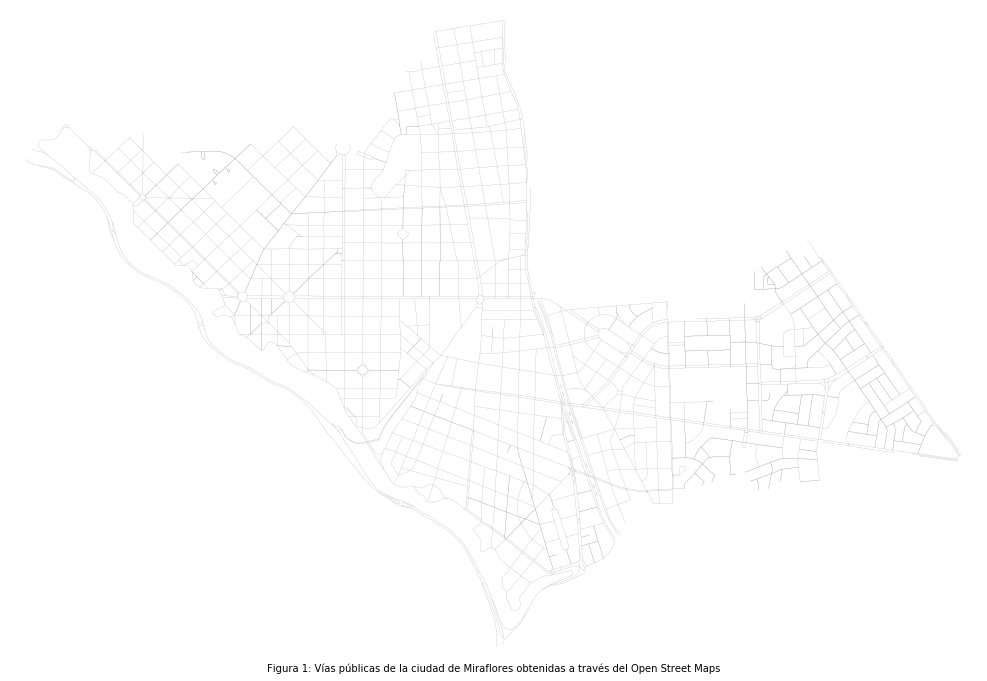

In [12]:
fig

# Treat Data <a class='tocSkip'>

## Potholes to shapely <a class='tocSkip'>

In [13]:
pot_holes = phc.treat_potholes_points(pot_holes)

# Conectando Alertas a las Calles

In [14]:
# We use projected graph for better accuracy in KDTree method
edges_with_potholes = phc.match_roads_to_points(city, pot_holes, G_proj)

In [15]:
nx.set_edge_attributes(G_proj, 0, 'alerts_count')
nx.set_edge_attributes(G_proj, 0, 'interactions')
nx.set_edge_attributes(G_proj, edges_with_potholes)

In [16]:
nx.set_edge_attributes(G, 0, 'alerts_count')
nx.set_edge_attributes(G, 0, 'interactions')
nx.set_edge_attributes(G, edges_with_potholes)

In [17]:
### Feito o match, iremos analisar os segmentos com os buracos
edges = ox.graph_to_gdfs(G, nodes=False) 

La siguiente imagen muestra todas las secciones de la calle donde se reportaron alertas de huecos, en las que la intensidad de los colores indica la cantidad de interacciones de los usuarios de la aplicación con dichas alertas.

In [18]:
interactions = [d['interactions'] for _,_,d in G_proj.edges(data=True)]
norm = colors.Normalize(vmin=0, vmax=max(interactions))
scalarMap  = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('autumn_r'))

edges_color = list(map(colors.to_rgba, [scalarMap.to_rgba(d['interactions']) if d['interactions'] > 0 else '#bfbfbf' for _,_,d in G_proj.edges(data=True)]))

edges_width = [3 if d['alerts_count'] > 0 else 0.2 for _,_,d in G_proj.edges(data=True)]

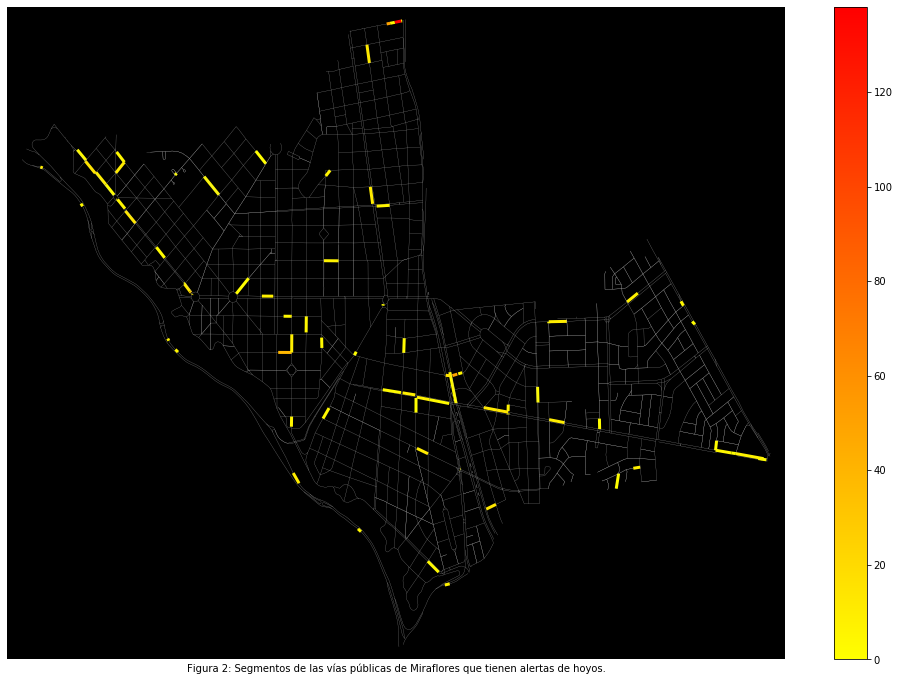

In [19]:
fig.clear()
ax.clear()
fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=12, edge_color=edges_color,edge_linewidth=edges_width,
                       show=False, axis_off=False)
ax.set_facecolor('k')
ax.margins(0)
ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
cb = fig.colorbar(scalarMap)
ax.set_xlabel(f"Figura 2: Segmentos de las vías públicas de {city} que tienen alertas de hoyos.");
fig

# Estadísticas descriptivas

In [20]:
stats = phc.generate_basic_stats(city, G)#, cost_per_meter, lane_size, avg_lane)

La siguiente tabla resume algunas estadísticas sobre las calles de la ciudad, indicando cuántos de sus segmentos tienen hoyos y estimando su representación en el total de las vías.

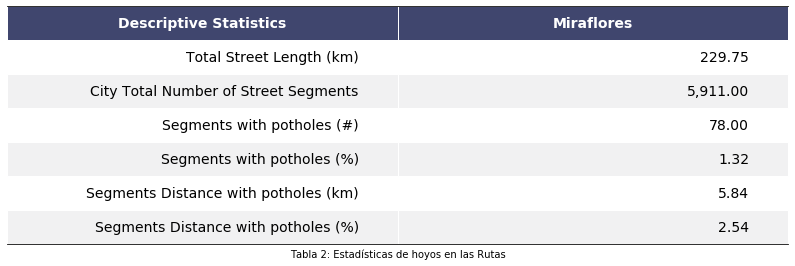

In [45]:
stats_table = stats.copy()
stats_table[city] = stats[city].apply(lambda x: f"{x:,.2f}")
stats_table.index.names = ["Descriptive Statistics"]
fig, ax, table = phc.render_mpl_table(stats_table.reset_index(), 'stats_table.png', city, col_width=7)
ax.set_xlabel(f"Tabla 2: Estadísticas de hoyos en las Rutas");

# Costo estimado

La fórmula de costeo es la siguiente: $Cost = Longitud * Ancho de Pista * Coste/m^2$, en el que el ancho y la longitud de la pista se dan en metros. En este caso, suponemos que los agujeros no son más amplios que el ancho de la vía, sólo una de las vias de una calle debe tenerse en cuenta en el coste total estimado de la reparación.

En la siguiente tabla se indican los valores de los parámetros asumidos en este informe y el coste estimado de reparación de todos los segmentos de calle con agujeros reportados en el periodo cubierto.

In [22]:
cost_table = phc.generate_cost_estimates(city, G, cost_per_meter, lane_size)
cost_table[city] = cost_table[city].apply(lambda x: f"{x:,.2f}")
cost_table.index.names = ['Estimated Cost Parameters and Value']

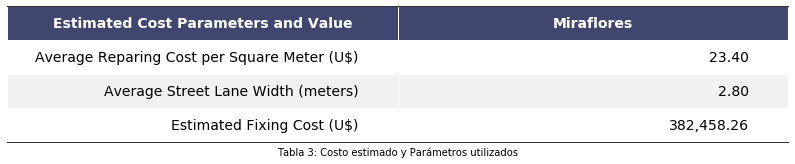

In [23]:
fig, ax, table = phc.render_mpl_table(cost_table.reset_index(), 'cost_table.png', city, col_width=7)
ax.set_xlabel(f"Tabla 3: Costo estimado y Parámetros utilizados");

In [24]:
# ax1 = edges['cost'].hist(figsize=[15,10])
# ax1.grid(axis='x')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.set_ylabel("Número de Segmentos de Rua")
# ax1.set_xlabel("Quantidade de Intereções nos Alertas dos Segmentos")
# ax1.set_title("Distribuição de Segmentos por Quantidade de Interações");

# Interacciones con Alertas de Agujeros

## Segmentos e Interacciones

El siguiente histograma indica la distribución de los segmentos de la calle de acuerdo con el número de interacciones que cada segmento obtuvo, sin contar aquellos sin interacción.

Es decir, las columnas de la derecha del siguiente gráfico indican los segmentos de calle con más quejas / reclamaciones, que representan las que más afectan al usuario.

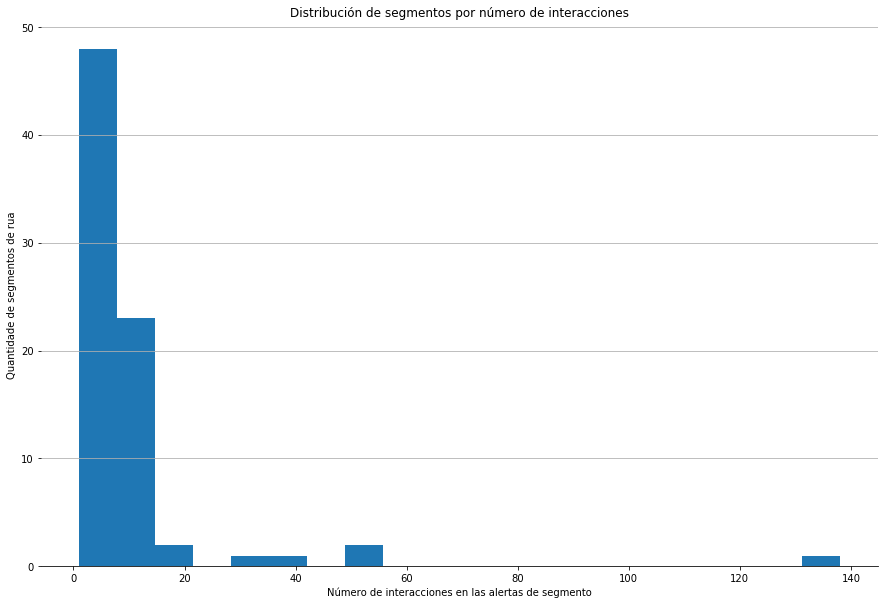

In [25]:
ax1 = edges[edges['interactions']>0]['interactions'].hist(figsize=[15,10], bins=20)
ax1.grid(axis='x')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel("Quantidade de segmentos de rua")
ax1.set_xlabel("Número de interacciones en las alertas de segmento")
ax1.set_title("Distribución de segmentos por número de interacciones");

## Principio de Pareto

In [26]:
edges = phc.estimate_cost(edges, cost_per_meter, lane_size)

In [27]:
edges = phc.calculate_pareto(edges)

La última figura muestra que pocos segmentos son responsables por muchas interacciones, mientras que hay varios segmentos con pocas interacciones de usuarios. Es decir, hay agujeros que causan un mayor impacto en el tráfico y el bienestar de los ciudadanos.

Explorando más a fondo esta relación de interacciones por segmento, queremos saber cuán cerca está el patrón observado del Principio de Pareto, es decir, si, en contraste con una distribuición uniforme, el 20% de los segmentos es responsables por el 80% de las interacciones. De hecho, la imagen abajo muestra que,  la distribuición observada contrasta con la distribuición real y uniforme.

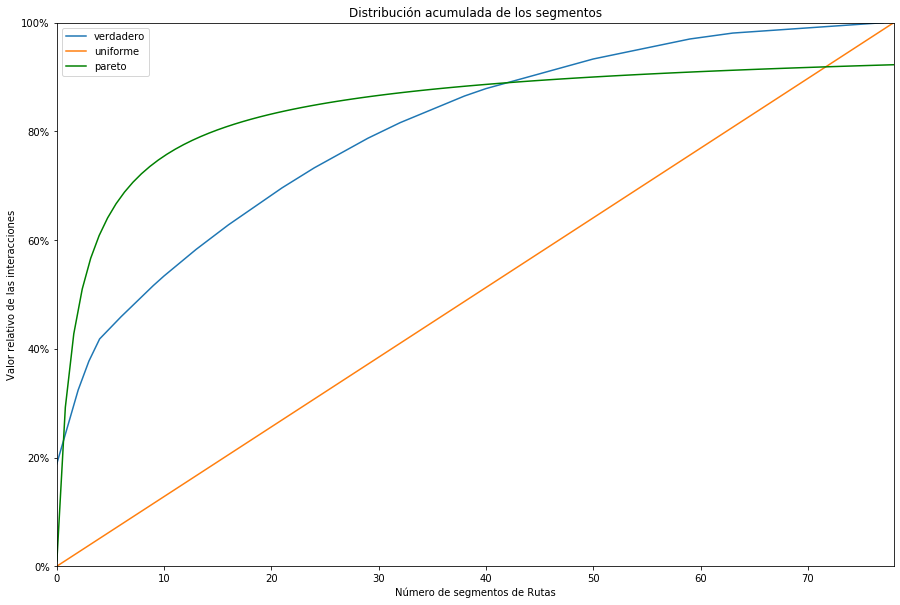

In [28]:
# calculating Pareto parameters
x_max = edges[['pareto']].dropna().shape[0]
b= -(np.log(0.2)/np.log(0.2*edges[['pareto']].dropna().shape[0]))
loc= -1
x = np.linspace(pareto.ppf(0.01, b, loc=loc), x_max, 100)

# plotting graphs
plot = edges[['pareto']].sort_values(by='pareto').rename(columns={"pareto":"verdadero"}).dropna().reset_index().plot(y='verdadero', figsize=(15,10))
fig = plot.get_figure()
plot.plot([0, x_max], [0,100], label='uniforme')
plot.plot(x, pareto.cdf(x, b, loc=loc)*100, 'g-', label='pareto')
plot.legend()
plot.set_ylim(0,100)
plot.set_xlim(0,x_max)
plot.set_yticklabels(['0%', '20%', '40%', '60%', '80%','100%'])
plot.set_title("Distribución acumulada de los segmentos")
plot.set_ylabel("Valor relativo de las interacciones")
plot.set_xlabel("Número de segmentos de Rutas")
fig.savefig(OUTPUT_PATH / "cumulative_distribution.png")

In [29]:
pareto = phc.summary_pareto(city, edges)

Con el objetivo de optimizar los recursos públicos y las restricciones presupuestarias, podemos formular una estrategia de reparación de carreteras que priorice los hoyos que causan mayores inconveniencias a los conductores. Esto es posible de inferir a través del número de interacciones con las alertas de los hoyos de los usuarios de Waze que transitan por la ciudad.

Clasificando los segmentos de la calle por su número de interacciones con alertas hacia abajo y calculando su coste de reparación, podemos identificar el porcentaje de reclamaciones que podrían ser atendidas dentro de los presupuestos diferentes. La siguiente tabla muestra esta información.

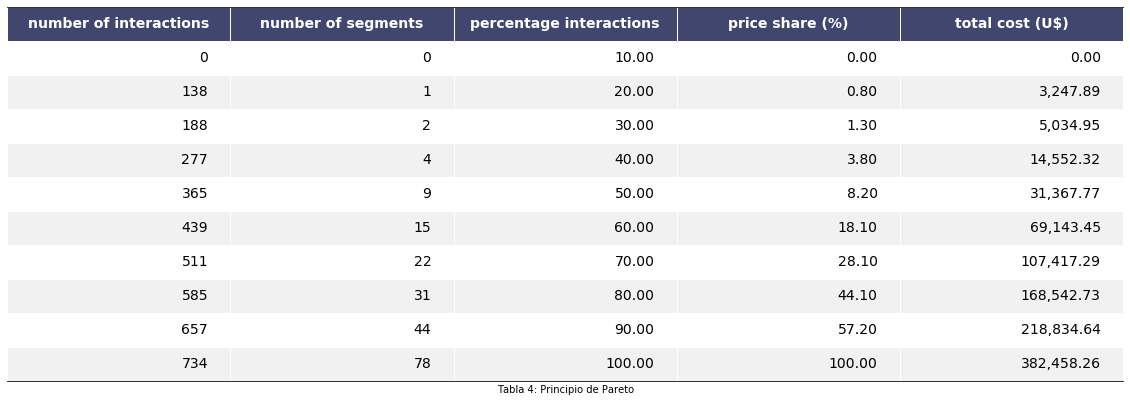

In [30]:
pareto_table = pareto.copy()
for col in pareto.columns:
    if col not in ['number of segments', 'number of interactions']:
        pareto_table[col] = pareto[col].apply(lambda x: f"{x:,.2f}")
fig, ax, table = phc.render_mpl_table(pareto_table[2::2], 'pareto_table.png', city)
ax.set_xlabel(f"Tabla 4: Principio de Pareto");

La siguiente imagen muestra la relación entre el porcentaje del coste total y el porcentaje de reclamaciones. Puede observarse que aplicando adecuadamente los recursos es posible atender un gran volumen de reclamaciones.

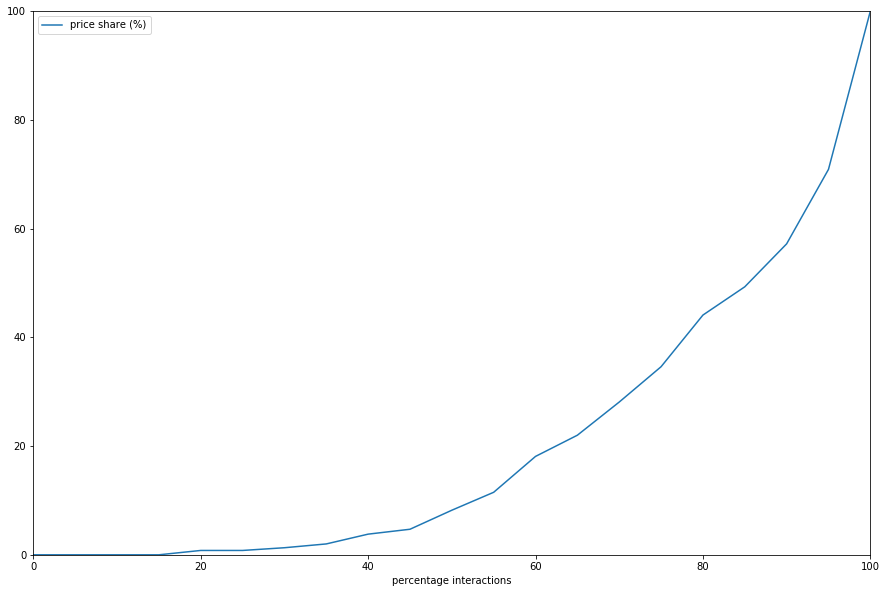

In [31]:
plot = pareto.plot(x='percentage interactions', y='price share (%)', figsize=(15,10))
fig = plot.get_figure()
plot.set_ylim(0,100)
plot.set_xlim(0,100)
fig.savefig(OUTPUT_PATH / "priceshare x percentage_interactions.png")

\newpage

## Mapas de carreteras con más quejas

Las siguientes imágenes indican las posiciones de los agujeros que que concentran más interaciones de los usuarios.

In [32]:
Gcopy = G_proj.copy()
nx.set_edge_attributes(Gcopy, 0, 'alerts_count')
nx.set_edge_attributes(Gcopy, 0, 'interactions')
edges_pareto = edges[edges['alerts_count']>0].loc[:,['u','v', 'key', 'alerts_count', 'interactions', 'cost', 'pareto']].rename(columns={'key':'k'})

In [33]:
top = 10
if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Localización de los hoyos que concentran el <b>{top}%</b> de las quejas."""))
    print(f"Costo estimado de la reparación en U${pareto.loc[pareto['percentage interactions']==top, 'total cost (U$)'].iloc[0]:,.2f}")
    edges_with_potholes_pareto = edges_pareto[edges_pareto['pareto'] < top].groupby(['u','v','k']).sum().to_dict('index')
    nx.set_edge_attributes(Gcopy, edges_with_potholes_pareto)

In [34]:
phc.plot_graph_potholes(Gcopy) if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0 else None

In [35]:
top = 25
if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Localización de los hoyos que concentran el <b>{top}%</b> de las quejas."""))
    print(f"Costo estimado de la reparación en U${pareto.loc[pareto['percentage interactions']==top, 'total cost (U$)'].iloc[0]:,.2f}")
    edges_with_potholes_pareto = edges_pareto[edges_pareto['pareto'] < top].groupby(['u','v','k']).sum().to_dict('index')
    nx.set_edge_attributes(Gcopy, edges_with_potholes_pareto)

Localización de los hoyos que concentran el <b>25%</b> de las quejas.

Costo estimado de la reparación en U$3,247.89


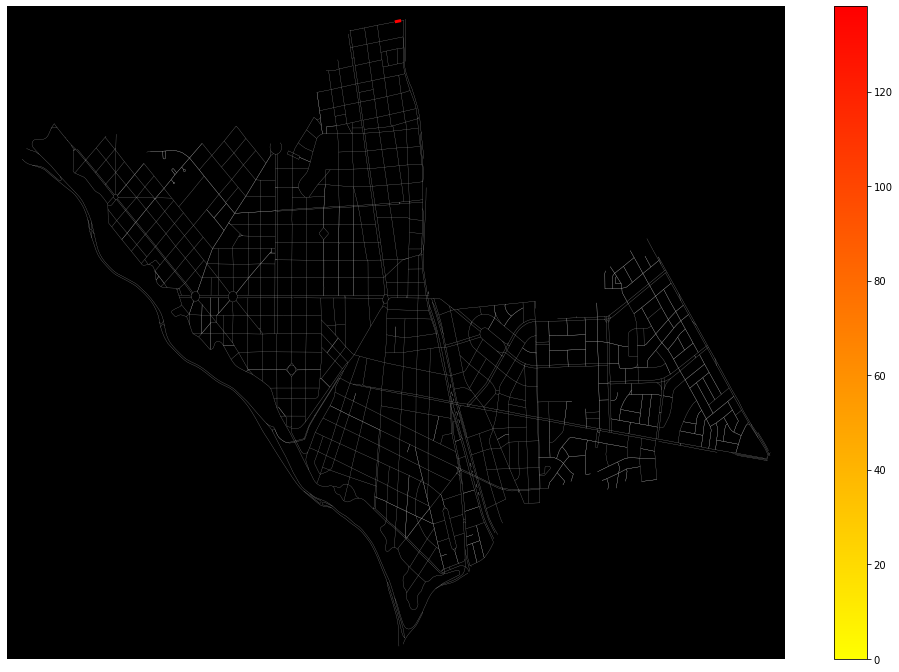

In [37]:
phc.plot_graph_potholes(Gcopy) if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0 else None

\newpage

In [38]:
top = 50
if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Localización de los hoyos que concentran el <b>{top}%</b> de las quejas."""))
    print(f"Costo estimado de la reparación en U${pareto.loc[pareto['percentage interactions']==top, 'total cost (U$)'].iloc[0]:,.2f}")
    edges_with_potholes_pareto = edges_pareto[edges_pareto['pareto'] < top].groupby(['u','v','k']).sum().to_dict('index')
    nx.set_edge_attributes(Gcopy, edges_with_potholes_pareto)

Localización de los hoyos que concentran el <b>50%</b> de las quejas.

Costo estimado de la reparación en U$31,367.77


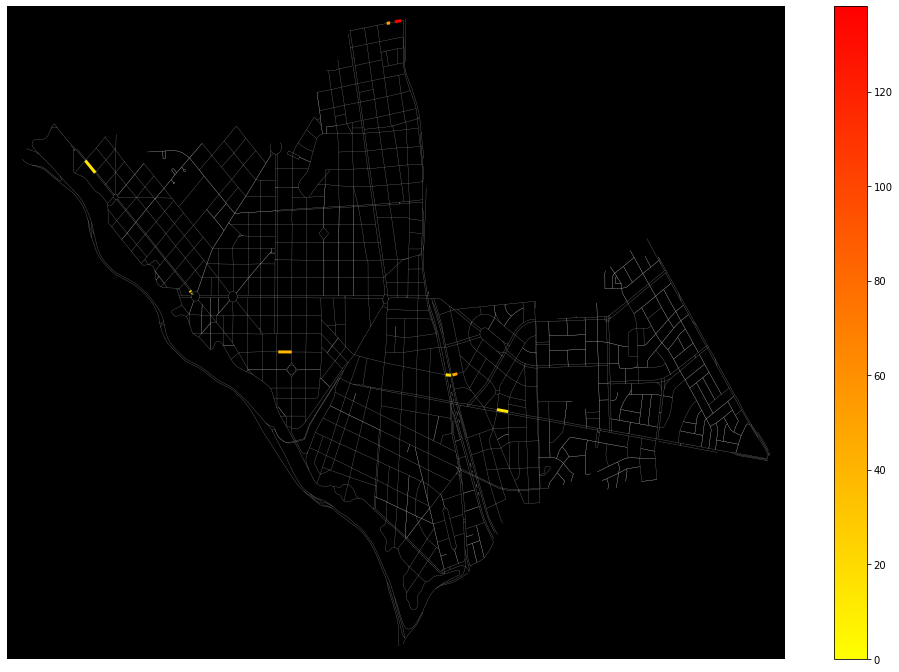

In [39]:
phc.plot_graph_potholes(Gcopy) if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0 else None

# Anexos

In [40]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', 'pareto']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

In [41]:
top = 10
if edges_table[edges_table['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Tabla de Rutas que concentran el {top}% de las quejas."""))
    with pd.option_context('display.max_rows', None):
        print(edges_table.loc[edges_table['pareto'] < top, ['street', 'interactions', 'cost']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index())

In [42]:
top = 25
if edges_table[edges_table['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Tabla de Rutas que concentran el {top}% de las quejas."""))
    with pd.option_context('display.max_rows', None):
        print(edges_table.loc[edges_table['pareto'] < top, ['street', 'interactions', 'cost']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index())

Tabla de Rutas que concentran el 25% de las quejas.

                    street  interactions        cost
0  Avenida Andrés Aramburú           138  3247.89192


In [43]:
top = 50
if edges_table[edges_table['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Tabla de Rutas que concentran el {top}% de las quejas."""))
    with pd.option_context('display.max_rows', None):
        print(edges_table.loc[edges_table['pareto'] < top, ['street', 'interactions', 'cost']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index())

Tabla de Rutas que concentran el 50% de las quejas.

                      street  interactions        cost
0    Avenida Andrés Aramburú           188  5034.94992
1     Calle José Félix Olcay            65  5287.92264
2              Calle Francia            39  6944.72688
3       Avenida Del Ejército            30   745.68312
4     Avenida Perez Araníbar            15  7271.01648
5  Avenida Alfredo Benavides            14  5770.93608
6           Óvalo José Pardo            14   312.53040


# Export to Kepler <a class='tocSkip'>

In [44]:
kepler_data = phc.export_kepler(city, edges)